## Importing Packages

In [3]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Loading and Cleaning Data

In [2]:
# read in data
proteins = nx.read_weighted_edgelist("protein_data.txt",comments="#",nodetype=str)
proteins_no_essentials = proteins.copy()

In [3]:
# convert essential proteins to data frame
essentials = pd.read_csv('Data File - Essential Proteins.csv',header=None)
essentials.columns = ['Code', 'Name', 'Scientific Name', 'Technical Code', 'Description']

In [4]:
# remove essential proteins
for node in essentials['Name']:
    if node in proteins_no_essentials.nodes():
        proteins_no_essentials.remove_node(node)

In [5]:
# remove low confidence interactions
threshold = 700
for edge in proteins_no_essentials.edges():
    weight = list(proteins_no_essentials.get_edge_data(edge[0],edge[1]).values())
    if weight[0] <= threshold:
        proteins_no_essentials.remove_edge(edge[0],edge[1])

for edge in proteins.edges():
    weight = list(proteins.get_edge_data(edge[0],edge[1]).values())
    if weight[0] <= threshold:
        proteins.remove_edge(edge[0],edge[1])

In [6]:
# convert graphs to unweighted
def drop_weights(G):
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight',None)

drop_weights(proteins_no_essentials)
drop_weights(proteins)

## Isolating the Largest Connected Component (contains target nodes)

In [7]:
largest_subgraph = max(nx.connected_components(proteins_no_essentials), key=len)
data = proteins_no_essentials.subgraph(largest_subgraph)

largest_subgraph_ = max(nx.connected_components(proteins), key=len)
proteins = proteins.subgraph(largest_subgraph_)

## Calculating Centrality Measures

No Essentials:

In [8]:
# Degree Centrality
degree_centrality = nx.degree_centrality(data)

In [9]:
# Closeness Centrality
closeness_centrality = nx.closeness_centrality(data)

In [10]:
# Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(data)

In [11]:
# Betweeness Centrality
betweenness_centrality = nx.betweenness_centrality(data)

In [12]:
# Subgraph Centrality
subgraph_centrality = nx.subgraph_centrality(data)

In [13]:
# Information Centrality
information_centrality = nx.information_centrality(data)

In [14]:
# Laplacian Centrality
#laplacian_centrality = nx.laplacian_centrality(data,weight=None)

Whole Network:

In [15]:
# Degree Centrality:
deg = nx.degree_centrality(proteins)

In [16]:
# Closeness Centrality
close = nx.closeness_centrality(proteins)

In [17]:
# Eigenvector Centrality
eig = nx.eigenvector_centrality(proteins)

In [18]:
# Betweenness Centrality:
bet = nx.betweenness_centrality(proteins)

In [19]:
# Subgraph Centrality:
sub = nx.subgraph_centrality(proteins)

In [20]:
# Information Centrality:
inf = nx.information_centrality(proteins)

In [21]:
# Laplacian Centrality:
#lap = nx.laplacian_centrality(proteins)

## Forming Dataframes Containing Centralities

In [22]:
# No essentials
names = list(degree_centrality.keys())
degree_list = np.array(list(degree_centrality.values()))
closeness_list = np.array(list(closeness_centrality.values()))
eigenvector_list = np.array(list(eigenvector_centrality.values()))
betweenness_list = np.array(list(betweenness_centrality.values()))
subgraph_list = np.array(list(subgraph_centrality.values()))
information_list = np.array(list(information_centrality.values()))


centrality_df = pd.DataFrame()
centrality_df['Names'] = names
centrality_df['Degree'] = degree_list
centrality_df['Closeness'] = closeness_list
centrality_df['Eigenvector'] = eigenvector_list
centrality_df['Betweenness'] = betweenness_list
centrality_df['Subgraph'] = subgraph_list
centrality_df['Information'] = information_list
#centrality_df['Laplacian'] = laplacian_list

Now, from the data containing all the nodes, we only consider the essential proteins. This will allow us to only use nodes we consider to be "important" when designing our index.

In [23]:
# filtering out essential nodes:
essential_nodes = []
for node in essentials['Name']:
    if node in proteins.nodes():
        essential_nodes.append(node)

# creating dataframe for essential proteins:
essential_centralities = pd.DataFrame()
essential_centralities['Name'] = essential_nodes


# creating vectors for centralities of essential nodes:
ess_deg = []
ess_close = []
ess_eig = []
ess_bet = []
ess_sub = []
ess_inf = []
#ess_lap = []
for node in essential_centralities['Name']:
    ess_deg.append(deg[node])
    ess_close.append(close[node])
    ess_eig.append(eig[node])
    ess_bet.append(bet[node])
    ess_sub.append(sub[node])
    ess_inf.append(inf[node])
    #ess_lap.append(lap[node])

In [24]:
ess_deg = np.array(ess_deg)
ess_close = np.array(ess_close)
ess_eig = np.array(ess_eig)
ess_bet = np.array(ess_bet)
ess_sub = np.array(ess_sub)
ess_inf = np.array(ess_inf)
#ess_lap = np.array(ess_lap)

essential_centralities['Degree'] = ess_deg 
essential_centralities['Closeness'] = ess_close  
essential_centralities['Eigenvector'] = ess_eig
essential_centralities['Betweenness'] = ess_bet
essential_centralities['Subgraph'] = ess_sub  
essential_centralities['Information'] = ess_inf
#essential_centralities['Laplacian'] = ess_lap

## Correlation Matrices and Pairwise Scatter Plot Matrices:

### Essential Proteins:

In [25]:
# Correlation Matrix
corr_ess = essential_centralities[['Degree', 'Closeness', 'Eigenvector', 'Betweenness', 'Subgraph', 'Information']].corr()
corr_ess.style.background_gradient(cmap='coolwarm')

,Degree,Closeness,Eigenvector,Betweenness,Subgraph,Information
Degree,1.000000,0.728435,0.921662,0.312046,0.854093,0.547215
Closeness,0.728435,1.000000,0.559394,0.386246,0.485162,0.819557
Eigenvector,0.921662,0.559394,1.000000,0.125624,0.935009,0.365260
Betweenness,0.312046,0.386246,0.125624,1.000000,0.135558,0.194820
Subgraph,0.854093,0.485162,0.935009,0.135558,0.000000,0.273840
Information,0.547215,0.819557,0.365260,0.194820,0.273840,1.000000


<Figure size 640x480 with 0 Axes>

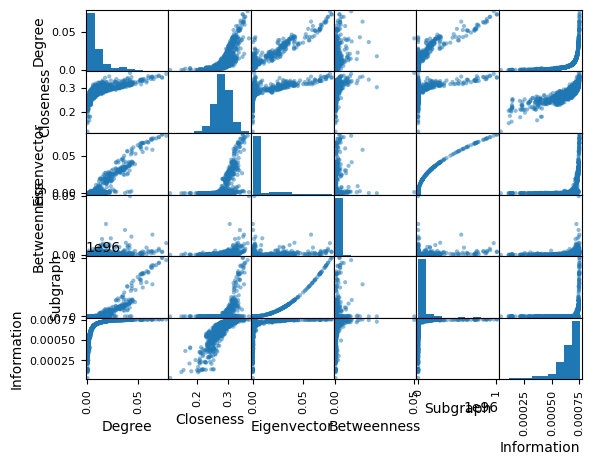

In [27]:
# Scatter Matrix
plt.figure()
pd.plotting.scatter_matrix(essential_centralities[['Degree', 'Closeness', 'Eigenvector', 'Betweenness', 'Subgraph', 'Information']], diagonal='hist')
plt.show()

To standardise the data, we will divide each column by its l2 norm.

In [43]:
# Normalised Datasets:
normalised_centralities = essential_centralities.copy()
colnames = list(normalised_centralities.columns)
for col in colnames:
    if col != "Name":
        vals = np.array(normalised_centralities[col])
        l2 = np.linalg.norm(vals)
        newcol = vals / l2
        normalised_centralities[col] = newcol

<Figure size 640x480 with 0 Axes>

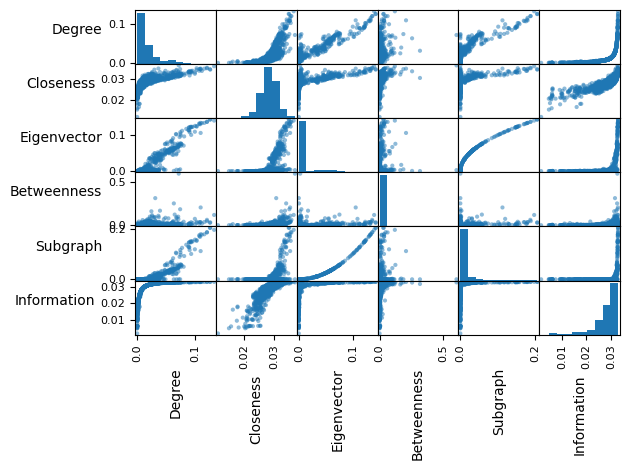

In [74]:
# Scatter Matrix
plt.figure()
axes = pd.plotting.scatter_matrix(normalised_centralities[['Degree', 'Closeness', 'Eigenvector', 'Betweenness', 'Subgraph', 'Information']], diagonal='hist')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

In [87]:
normalised_centralities.to_excel("~/MATH3888/Files/normalised_centralities.xlsx",
                                sheet_name = 'Normalised Essential Centralities')

In [88]:
essential_centralities.to_excel("~/MATH3888/Files/essential_centralities.xlsx",
                                sheet_name = 'Essential Centralities')

In [89]:
centrality_df.to_excel("~/MATH3888/Files/centralities.xlsx",
                                sheet_name = 'All Centralities')

In [18]:
centrality_df = pd.read_excel("~/MATH3888/Files/Datasets/centralities.xlsx")

all_centrality_normalised = centrality_df.copy()
all_centrality_normalised = all_centrality_normalised.drop(['Unnamed: 0', 'Names'], axis=1)
colnames = list(all_centrality_normalised.columns)
for col in colnames: 
    vals = np.array(all_centrality_normalised[col])
    l2 = np.linalg.norm(vals)
    newcol = vals / l2
    all_centrality_normalised[col] = newcol

In [19]:
np.mean(all_centrality_normalised

,Degree,Closeness,Eigenvector,Betweenness,Subgraph,Information
0,0.002422,0.012440,7.754327e-07,0.000000,8.134305e-12,0.009611
1,0.006574,0.016178,6.179776e-05,0.001415,5.181284e-08,0.018436
2,0.002422,0.015505,3.611622e-04,0.014099,1.775311e-06,0.013003
3,0.001038,0.014638,5.954906e-06,0.000000,4.794612e-10,0.010530
4,0.006920,0.017472,1.218518e-03,0.006611,2.022889e-05,0.018602
...,...,...,...,...,...,...
4390,0.000692,0.009801,9.446209e-11,0.000000,1.088853e-19,0.005619
4391,0.001730,0.010252,7.588324e-11,0.000088,7.584973e-20,0.009242
4392,0.003806,0.011977,4.388996e-08,0.001441,2.565271e-14,0.015014
4393,0.000692,0.011934,5.056897e-09,0.000286,3.452951e-16,0.005897


In [ ]:
plt.hist(essential_centralities['Degree']+0.00001)

plt.hist(np.log(essential_centralities['Degree']+0.00001))


np.log(essential_centralities['Degree']+0.00001)
